# Steane's Code Under Random Pauli Error
**Author:** Julia Cen

## What is the Steane's Code?

One of the major challenges faced in quantum computation is how susceptible quantum states are to errors, for example, from interactions with the environment. One way to tackle this is with quantum error correction codes. In this notebook, we will look at one example called Steane's code. This code was developed by Steane in 1996 [1]. It is a [[7,1,3]] quantum code, a type of Calderbank–Shor–Steane (CSS) code (stabilizers are only of X-type or Z-type) based on the classical [7,4,3] Hamming code. The code encodes 1 logical qubit into 7 physical qubits with code distance 3 (minimum weight/number of Pauli errors of a logical operator such that it commutes with all stabilizers, but is not a stabilizer itself). Steane's code can detect and correct $\frac{d-1}{2}=1$ arbitrary qubit errors.

## Building Steane's Code

We will write Steane's code to help us correct a bit flip (X), phase flip (Z), or bit+phase flip (Y) for each independent qubit in a $|x>$ state formed from a given Boolean string $x\in \mathbb{F}^n_2$.

### The Code Structure

1) Encoding $|x>$ to a logical $|x_L>$ state for Steane's code
2) Run the encoded logical state $|x_L>$ through a Pauli error channel
3) Measure syndromes to find where 1 qubit errors occurred 
4) Apply recovery operations to fix any 1 qubit errors
5) Measure the data qubits and decode the result to see how the recovery went

In [1]:
from qiskit import *
from qiskit.quantum_info import *
from qiskit.circuit.library import *
from qiskit.visualization import *
from qiskit_aer import AerSimulator

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Latex

### Encoding $|x>$

The Steane's code encodes each qubit into 7 physical qubits. So for the state $|x>$ where $x\in \mathbb{F}_2^n$, we will need $7n$ physical qubits to encode the state. 

Steane's code [2] is defined by the stabilizer group of 6 commuting operators. 3 of X-type and 3 of Z-type

\begin{align*}
M_0 &=X_4X_3X_2X_1, \,\,
M_1=X_5X_3X_2X_0, \,\,
M_2=X_6X_3X_1X_0, \\
N_0&=Z_4Z_3Z_2Z_1, \,\,\,\,\,\,\,
N_1=Z_5Z_3Z_2Z_0, \,\,\,\,\,\,\,
N_2=Z_6Z_3Z_1Z_0.
\end{align*}

For a single qubit basis states $|0>$ and $|1>$, the logical $|x_L>$ states for Steane's code are

\begin{align*}
|0_L> &=\frac{1}{\sqrt{8}} (I+M_0)(I+M_1)(I+M_2)|0>^{\otimes 7}\\
&= \frac{1}{\sqrt{8}}(|0000000>+|1010101>+|0110011>+|1100110>+|0001111>+|1011010>+|0111100>+|1101001>)\\
|1_L> &=\frac{1}{\sqrt{8}} (I+M_0)(I+M_1)(I+M_2)|1>^{\otimes 7}\\
&= \frac{1}{\sqrt{8}}(|1111111>+|0101010>+|1001100>+|0011001>+|1110000>+|0100101>+|1000011>+|0010110>)
\end{align*}

which are just the superpositions of binary basis vectors from codewords of the [7,4,3] Hamming code that have even and odd numbers of 1s, respectively. An important property to note is that logical states are the eigenvectors of the stabilizer operators with eigenvalue 1. This is key for detecting errors later.

$$
M_i|x_L>=N_i|x_L>=|x_L>.
$$

Let us now first prepare the logical state $|x_L>$ given a boolean string $x\in\mathbb{F}^n_2$ [3].

In [2]:
# # define a boolean string
# xstring = "0"

# # length of boolean string
# n = len(xstring)

# # create a circuit of 7n qubits
# steane_qubits = QuantumRegister(size=7*n, name=f"steane")
# steane_code = QuantumCircuit(steane_qubits, name="steane_circuit")

In [3]:
# prepare the logical |x_L> state
def encode(xstring, steane_qubits, steane_code):
    for i, bit in enumerate(xstring):
        if bit == '0':
            steane_code.cx(steane_qubits[7*i+6],steane_qubits[7*i+4])
            steane_code.cx(steane_qubits[7*i+6],steane_qubits[i+5])
            steane_code.h(steane_qubits[7*i+0])
            steane_code.cx(steane_qubits[7*i+0],steane_qubits[7*i+3])
            steane_code.cx(steane_qubits[7*i+0],steane_qubits[7*i+5])
            steane_code.cx(steane_qubits[7*i+0],steane_qubits[7*i+6])
            steane_code.h(steane_qubits[7*i+1])
            steane_code.cx(steane_qubits[7*i+1],steane_qubits[7*i+3])
            steane_code.cx(steane_qubits[7*i+1],steane_qubits[7*i+4])
            steane_code.cx(steane_qubits[7*i+1],steane_qubits[i+6])   
            steane_code.h(steane_qubits[7*i+2])
            steane_code.cx(steane_qubits[7*i+2],steane_qubits[7*i+3])
            steane_code.cx(steane_qubits[7*i+2],steane_qubits[7*i+4])
            steane_code.cx(steane_qubits[7*i+2],steane_qubits[7*i+5])
        else:
            steane_code.x(steane_qubits[7*i+6])
            steane_code.cx(steane_qubits[7*i+6],steane_qubits[7*i+4])
            steane_code.cx(steane_qubits[7*i+6],steane_qubits[7*i+5])
            steane_code.h(steane_qubits[7*i+0])
            steane_code.cx(steane_qubits[7*i+0],steane_qubits[7*i+3])
            steane_code.cx(steane_qubits[7*i+0],steane_qubits[7*i+5])
            steane_code.cx(steane_qubits[7*i+0],steane_qubits[7*i+6])
            steane_code.h(steane_qubits[7*i+1])
            steane_code.cx(steane_qubits[7*i+1],steane_qubits[7*i+3])
            steane_code.cx(steane_qubits[7*i+1],steane_qubits[7*i+4])
            steane_code.cx(steane_qubits[7*i+1],steane_qubits[7*i+6])   
            steane_code.h(steane_qubits[7*i+2])
            steane_code.cx(steane_qubits[7*i+2],steane_qubits[7*i+3])
            steane_code.cx(steane_qubits[7*i+2],steane_qubits[7*i+4])
            steane_code.cx(steane_qubits[7*i+2],steane_qubits[7*i+5])

# encode(xstring, steane_qubits, steane_code)
# display(steane_code.draw(output="mpl"))
# display(Statevector(steane_code).draw(output="Latex"))

### Simulating Noise

Now, we simulate noise by running the encoded logical state $|x_L>$ through a Pauli error channel. This error channel will apply for each qubit, an X,Y or Z error with a given probability $p\leq 3$. In other words:

$$
\mathbb{P}(\text{no error})=1-3p,
$$
$$
\mathbb{P}(\text{X error})=\mathbb{P}(\text{Y error})=\mathbb{P}(\text{Z error})=p.
$$

To create this, we generate a random number r,  between 0 and 1. If the random number is $0\leq r < p$, we apply a X error, $p\leq r < 2p$, we apply a Y error, $2p\leq r < 3p$, we apply a Z error, or no error otherwise.

In [4]:
# define the Pauli error channel 
def error(p, steane_qubits, steane_code):
    for qubit in range(7*n):
        r = np.random.rand()
        if r < p:
            steane_code.x(qubit)
            # print(f"Qubit {qubit}: X error applied")
        elif r < 2*p:
            steane_code.y(qubit)
            # print(f"Qubit {qubit}: Y error applied")
        elif r < 3*p:
            steane_code.z(qubit)
            # print(f"Qubit {qubit}: Z error applied")
      # else:
            # print(f"Qubit {qubit}: No error applied")
    
# p=0.05
# steane_code.barrier()
# error(p, steane_qubits, steane_code)
# display(steane_code.draw(output="mpl"))
# display(Statevector(steane_code).draw(output="Latex"))

### Error Detection for 1 Qubit Errors

Now we want to measure the syndromes to find where 1 qubit errors occurred. Let us first define the parity check matrix coming from the [7,4,3] Hamming code which are the same for both X and Z errors

$$
H_X=H_Z=\begin{pmatrix}
0 & 0 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 1 & 0 & 0 & 1 & 1\\
1 & 0 & 1 & 0 & 1 & 0 & 1
\end{pmatrix}.
$$

The columns are syndromes for the corresponding $X,Z$ errors that help us to decode. Below are syndrome to $X,Z$ error recipe:

\begin{align}
    \begin{pmatrix} 0 \\ 0 \\ 0 \end{pmatrix}   &\mapsto \text{no 1 qubit error} \\
    \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}   &\mapsto X_0, Z_0 \\
    \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}   &\mapsto X_1, Z_1 \\
    \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}   &\mapsto X_2, Z_2 \\
    \begin{pmatrix} 1 \\ 1 \\ 0 \end{pmatrix}   &\mapsto X_3, Z_3 \\
    \begin{pmatrix} 0 \\ 1 \\ 1 \end{pmatrix}   &\mapsto X_4, Z_4 \\
    \begin{pmatrix} 1 \\ 0 \\ 1 \end{pmatrix}   &\mapsto X_5, Z_5 \\
    \begin{pmatrix} 1 \\ 1 \\ 1 \end{pmatrix}   &\mapsto X_6, Z_6 \\
\end{align}

Note $Y=iXZ$, so Y errors can also be detected and corrected. For each logical qubit, we introduce 3 ancilla qubits for the X syndrome checks and 3 ancilla qubits for the Z syndrome checks. We write a code with controlled X and X gates to collect the parity of bit and phase flips, make measurements, and store them on classical bits. The rows of the parity check matrix are the stabilizers, which tell us which qubits to make the controls, and they act on the corresponding target ancillas.


In [5]:
# # parity check matrix
# H = np.array([[1, 1, 1, 1, 0, 0,0],
#               [1, 1, 0, 0, 1, 1, 0],
#               [1, 0, 1, 0, 1, 0, 1]])

# # create ancillas for each 7-qubits block to extract syndromes
# qubits_for_Z_checks = AncillaRegister(3*n, name=f"Zcheck")
# qubits_for_X_checks = AncillaRegister(3*n, name=f"Xcheck")
# steane_code.add_register(qubits_for_X_checks, qubits_for_Z_checks)

# # create classical bits for each 7-qubits block storing syndrome measurements
# Z_syndromes = [ClassicalRegister(3, f"s_Z_{i}") for i in range(n)]
# X_syndromes = [ClassicalRegister(3, f"s_X_{i}") for i in range(n)]
# for reg in Z_syndromes + X_syndromes:
#     steane_code.add_register(reg)

In [6]:
# syndrome extraction
def syndromeextraction(steane_qubits, qubits_for_X_checks, qubits_for_Z_checks, reg, steane_code, H):
    
    # extract X syndromes
    for i in range(n):
        # for j in range(7*i,7*i+7):
        for idx, row in enumerate(H):
            for qubit_index in np.where(row)[0]:
                steane_code.cx(steane_qubits[7*i+qubit_index], qubits_for_X_checks[3*i+idx])
    steane_code.barrier()
    
    # extract Z syndromes
    for k in range(7*n):
        steane_code.h(k)
    for i in range(n):
        # for j in range(7*i,7*i+7):
        for idx, row in enumerate(H):
            for qubit_index in np.where(row)[0]:
                steane_code.cx(steane_qubits[7*i+qubit_index], qubits_for_Z_checks[3*i+idx])
    for k in range(7*n):
        steane_code.h(k)
    steane_code.barrier()

    # measure
    for i in range(n):
        steane_code.measure(qubits_for_X_checks, X_syndromes[i])
        steane_code.barrier()
        
        steane_code.measure(qubits_for_Z_checks, Z_syndromes[i])
        steane_code.barrier()
                
# syndromeextraction(steane_qubits, qubits_for_X_checks, qubits_for_Z_checks, reg, steane_code, H)
# steane_code.draw(output="mpl")

### Correcting 1 Qubit Errors and Decoding

With the information where there are 1 qubit errors, we now apply recovery operations to fix them, decode and measure the data qubits to see how the recovery went. We use conditional corrections based on the measured X,Z syndromes. If a syndrome indicates an X error on qubit i, apply an X gate to correct it. If a syndrome indicates a Z error on qubit i, apply a Z gate to correct it.

In [7]:
# error correction
def errorcorrection(steane_qubits, reg, steane_code):
    for i in range(n):
        
        # X correction
        xx_block = X_syndromes[i]
        with steane_code.if_test((xx_block, 4)):
            steane_code.x(steane_qubits[6+7*i])
        
        with steane_code.if_test((xx_block, 2)):
            steane_code.x(steane_qubits[5+7*i])
        
        with steane_code.if_test((xx_block, 6)):
            steane_code.x(steane_qubits[4+7*i])
        
        with steane_code.if_test((xx_block, 1)):
            steane_code.x(steane_qubits[3+7*i])

        with steane_code.if_test((xx_block, 5)):
            steane_code.x(steane_qubits[2+7*i])
        
        with steane_code.if_test((xx_block, 3)):
            steane_code.x(steane_qubits[1+7*i])
        
        with steane_code.if_test((xx_block, 7)):
            steane_code.x(steane_qubits[0+7*i])

        steane_code.barrier()
        
        # Z correction
        zz_block = Z_syndromes[i]
        with steane_code.if_test((zz_block, 4)):
            steane_code.z(steane_qubits[6+7*i])
            
        with steane_code.if_test((zz_block, 2)):
            steane_code.z(steane_qubits[5+7*i])
        
        with steane_code.if_test((zz_block, 6)):
            steane_code.z(steane_qubits[4+7*i])
        
        with steane_code.if_test((zz_block, 1)):
            steane_code.z(steane_qubits[3+7*i])

        with steane_code.if_test((zz_block, 5)):
            steane_code.z(steane_qubits[2+7*i])
        
        with steane_code.if_test((zz_block, 3)):
            steane_code.z(steane_qubits[1+7*i])
        
        with steane_code.if_test((zz_block, 7)):
            steane_code.z(steane_qubits[0+7*i])

# steane_code.barrier()
# errorcorrection(steane_qubits, reg, steane_code)
# steane_code.draw(output="mpl")

Now we decode and measure our data qubits. If the data qubits are in the all zero state, then the error correction was successful.

Let us use Qiskit's AerSimulator to how how our Steane's code perform. 

In [8]:
def measure_steane(steane_qubits, steane_code):
    # measure
    steane_code.measure(steane_qubits, qubit_measurements)

In [9]:
simulator = AerSimulator()

In [10]:
# p=0.05
# steane_code
# encode(xstring, steane_qubits, steane_code)
# steane_code.barrier()
# error(p, steane_qubits, steane_code)
# steane_code.barrier()
# syndromeextraction(steane_qubits, qubits_for_X_checks, qubits_for_Z_checks, reg, steane_code, H)
# steane_code.barrier()
# errorcorrection(steane_qubits, reg, steane_code)
# steane_code.barrier()
# measure_steane(steane_qubits, steane_code)
# display(steane_code.draw(output="mpl"))

# rounds = 1000
# # Transpile the circuit for the backend
# compiled_circuit = transpile(steane_code, simulator)

# # Run the circuit
# job = simulator.run(compiled_circuit, shots=rounds)

# # Get the measurement counts
# counts = job.result().get_counts()

# # Print the counts
# counts

In [11]:
# distribution = {}
# for measurement in counts:
#     if measurement[:7] in distribution:
#         distribution[measurement[:7]] += counts[measurement] / rounds
#     else:
#         distribution[measurement[:7]] = counts[measurement] / rounds

# distribution

# Success Probability

In this section, we take the single qubit basis state $|0>$ and run it through Steane's code to see how the success probability changes for various values of $p$. The success probability is defined as the probability of measuring the logical all-zero single qubit state $|0_L>$ at the end.

In [12]:
# define a boolean string
xstring = "0"
# length of boolean string
n = len(xstring)

# parity check matrix
H = np.array([[1, 1, 1, 1, 0, 0,0],
              [1, 1, 0, 0, 1, 1, 0],
              [1, 0, 1, 0, 1, 0, 1]])

# define s set of p values
p_values = np.linspace(0, 0.3, 30)
# success probability
prob_all = []
# number of rounds
rounds = 100

# simulate over set of p values
for pp in p_values:
    success_counts = 0
    total_counts = 0

    for r in range(rounds):
        #create a circuit of 7n qubits
        steane_qubits = QuantumRegister(size=7*n, name=f"steane")
        steane_code = QuantumCircuit(steane_qubits, name="steane_circuit") 
        # create ancillas for each 7-qubits block to extract syndromes
        qubits_for_Z_checks = AncillaRegister(3*n, name=f"Zcheck")
        qubits_for_X_checks = AncillaRegister(3*n, name=f"Xcheck")
        steane_code.add_register(qubits_for_X_checks, qubits_for_Z_checks)
        # create classical bits for each 7-qubits block storing syndrome measurements
        Z_syndromes = [ClassicalRegister(3, f"s_Z_{i}") for i in range(n)]
        X_syndromes = [ClassicalRegister(3, f"s_X_{i}") for i in range(n)]
        for reg in Z_syndromes + X_syndromes:
            steane_code.add_register(reg)
        # classical bits for data
        qubit_measurements = ClassicalRegister(7*n, name=f"qmes")
        steane_code.add_register(qubit_measurements)

        # new encoding, errors, and correction for each shot
        encode(xstring, steane_qubits, steane_code)
        steane_code.barrier()
        # new errors for each run
        error(pp, steane_qubits, steane_code)
        steane_code.barrier()
        syndromeextraction(steane_qubits, qubits_for_X_checks, qubits_for_Z_checks, reg, steane_code, H)
        steane_code.barrier()
        errorcorrection(steane_qubits, reg, steane_code)
        steane_code.barrier()
        measure_steane(steane_qubits, steane_code)

        # run this single-shot circuit
        compiled_circuit = transpile(steane_code, simulator)
        job = simulator.run(compiled_circuit, shots=1)
        counts = job.result().get_counts()

        # check success
        v_0 = {"1010101", "0000000", "1100110", "0111100",
               "0110011", "0001111", "1101001", "1011010"}
        v_1 = {"1111111", "0101010", "1001100", "0011001",
               "1110000", "0100101", "1000011", "0010110"}

        for bitstring, shot_count in counts.items():
            chunks = [bitstring[i*7:(i+1)*7] for i in range(n)]
            for chunk, case in zip(chunks, xstring):
                if (case == "0" and chunk in v_0) or (case == "1" and chunk in v_1):
                    success_counts += shot_count
            total_counts += shot_count

    # success probability for this p
    success_prob = success_counts / total_counts
    prob_all.append(success_prob)

    print(f"p={pp:.3f}  Success: {success_counts}/{total_counts}  P_success={success_prob:.4f}")

p=0.000  Success: 100/100  P_success=1.0000
p=0.010  Success: 99/100  P_success=0.9900
p=0.021  Success: 96/100  P_success=0.9600
p=0.031  Success: 90/100  P_success=0.9000
p=0.041  Success: 90/100  P_success=0.9000
p=0.052  Success: 86/100  P_success=0.8600
p=0.062  Success: 87/100  P_success=0.8700
p=0.072  Success: 74/100  P_success=0.7400
p=0.083  Success: 73/100  P_success=0.7300
p=0.093  Success: 69/100  P_success=0.6900
p=0.103  Success: 73/100  P_success=0.7300
p=0.114  Success: 70/100  P_success=0.7000
p=0.124  Success: 72/100  P_success=0.7200
p=0.134  Success: 55/100  P_success=0.5500
p=0.145  Success: 63/100  P_success=0.6300
p=0.155  Success: 59/100  P_success=0.5900
p=0.166  Success: 57/100  P_success=0.5700
p=0.176  Success: 54/100  P_success=0.5400
p=0.186  Success: 52/100  P_success=0.5200
p=0.197  Success: 52/100  P_success=0.5200
p=0.207  Success: 51/100  P_success=0.5100
p=0.217  Success: 53/100  P_success=0.5300
p=0.228  Success: 48/100  P_success=0.4800
p=0.238  S

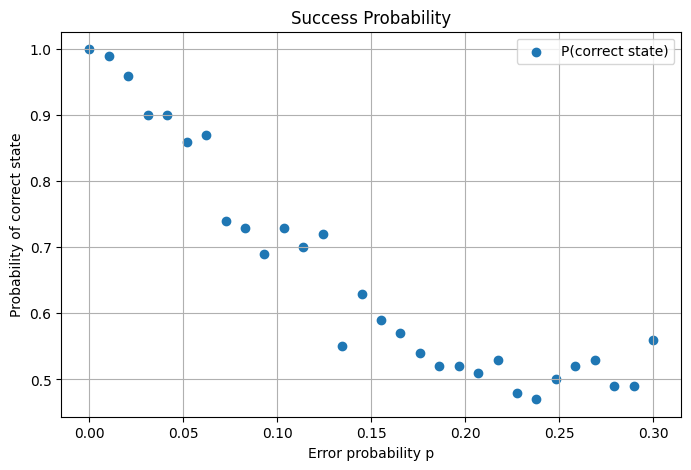

In [13]:
# plotting
plt.figure(figsize=(8, 5))
plt.scatter(p_values, prob_all, label="P(correct state)")
plt.xlabel("Error probability p")
plt.ylabel("Probability of correct state")
plt.title("Success Probability")
plt.grid(True)
plt.legend()
plt.show()

# References

[1] Steane, A., Error Correcting Codes in Quantum Theory, Physical Review Letters, 77(5), (1996).

[2] Nakahara, M. and Ohmi T., Quantum Computing From Linear Algebra to Physical Realizations, CRC Press, (2008).

[3] https://abdullahkhalid.com/qecft/stabilizer-codes/encoding-circuits-for-stabilizer-codes/